- [Preliminary analysis](#Preliminary-analysis)
- [Data cleaning and Feature selection](#Data-cleaning-and-Feature-selection)
- [Model selection: Round 1](#Model-selection:-Round-1)
- [Feature engineering](#Feature-engineering)
- [Model selection: Round 2 – TPOT](#Model-selection:-Round-2)
- [Util functions](#Util-functions)


[How to score 0.8134 🏅 in Titanic Kaggle Challenge](https://www.ahmedbesbes.com/blog/kaggle-titanic-competition)

## Preliminary analysis

In [17]:
import numpy as np 
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt

train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [18]:
# Baseline
train['Survived'].value_counts(normalize=True)

0    0.616162
1    0.383838
Name: Survived, dtype: float64

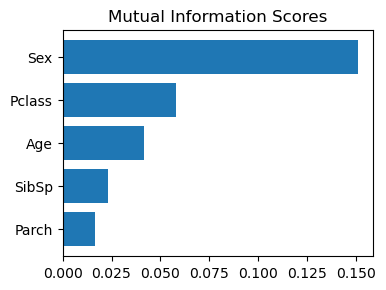

In [19]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(4, 3))
plot_mi_scores(mi_scores)

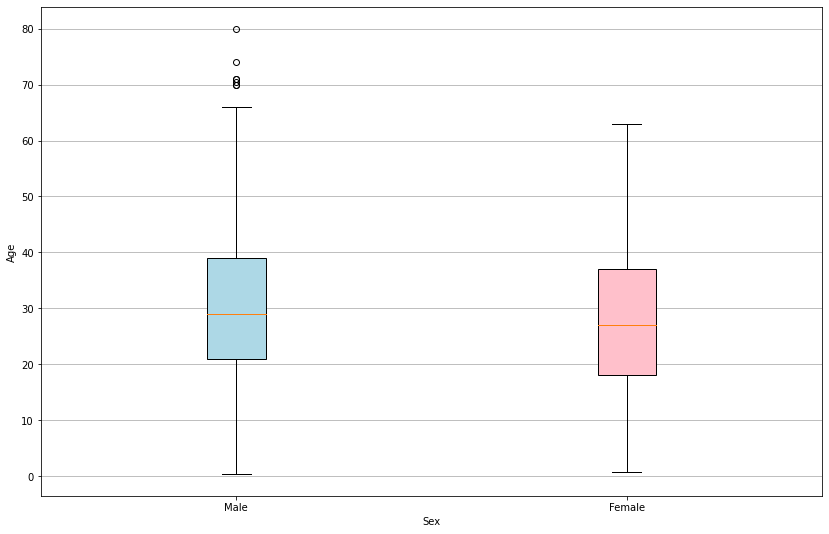

In [20]:
males = train[train['Sex'] == 'male']['Age'].dropna()
females = train[train['Sex'] == 'female']['Age'].dropna()

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(14, 9))

bplot = ax.boxplot([males, females],
                     vert=True,  
                     patch_artist=True, # paint boxes
                     labels=['Male', 'Female'])

colors = ['lightblue', 'pink']
for patch, color in zip(bplot['boxes'], colors):
    patch.set_facecolor(color)
    
ax.yaxis.grid(True)
ax.set_xlabel('Sex')
ax.set_ylabel('Age')
    
plt.show()

/Users/vadim/opt/anaconda3/lib/python3.8/site-packages/seaborn/categorical.py:1296: UserWarning: 5.9% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


<AxesSubplot:xlabel='Sex', ylabel='Age'>

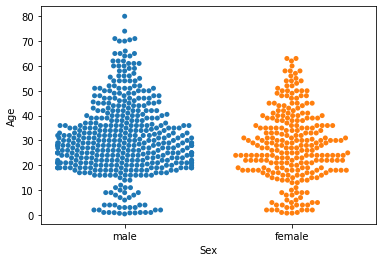

In [21]:
import seaborn as sns

sns.swarmplot(x=train['Sex'],
              y=train['Age'])

In [22]:
from scipy.stats import shapiro

# perform Shapiro-Wilk test
shapiro(test['Fare'].dropna())

ShapiroResult(statistic=0.539302408695221, pvalue=1.377181909954453e-31)

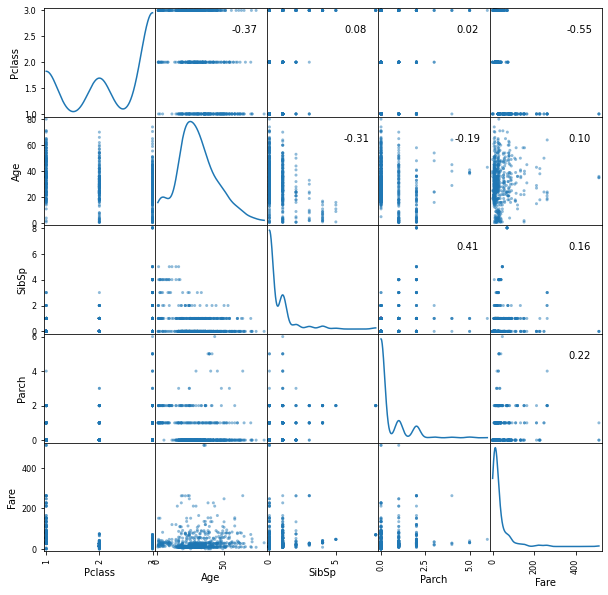

In [25]:
check_correlation(train[['Survived', 'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare']])

In [26]:
calculate_r_squared_combintations(train)

0.4 Pclass + Sex + Age + SibSp + Fare
0.4 Pclass + Sex + Age + SibSp + Parch
0.4 Pclass + Sex + Age + SibSp + Parch + Fare
0.4 Pclass + Sex + Age + SibSp
0.39 Pclass + Sex + Age + Fare
0.39 Pclass + Sex + Age + Parch + Fare
0.39 Pclass + Sex + Age + Parch
0.39 Pclass + Sex + Age
0.37 Pclass + Sex + Parch
0.37 Pclass + Sex + SibSp + Parch
0.37 Pclass + Sex + SibSp + Fare
0.37 Pclass + Sex + Fare
0.37 Pclass + Sex + Parch + Fare
0.37 Pclass + Sex
0.37 Pclass + Sex + SibSp + Parch + Fare


## Data cleaning and Feature selection

In [1015]:
train.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
test.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)

In [651]:
#X = pd.get_dummies(X)
#X_test = pd.get_dummies(X_test)

### "Fare" column fill-in

In [1016]:
# dummy strategy
test['Fare'].fillna(test['Fare'].median(), inplace=True)

In [630]:
# box-cox normalization
data = [train, test]

for dataset in data:
    posdata = dataset[dataset['Fare'] > 0]['Fare']
    bcdata, lam = stats.boxcox(posdata)

    x = np.empty_like(dataset['Fare'])
    x[dataset['Fare'] > 0] = bcdata
    x[dataset['Fare'] == 0] = -1/lam

    dataset['Fare'] = x

### "Age" column fill-in

In [1017]:
# dummy strategy
train['Age'].fillna(1000, inplace=True)
test['Age'].fillna(1000, inplace=True)

In [631]:
# "smart" fill-in with mean +/- std
#mean, std = train['Age'].apply(['mean', 'std'])
mean = train['Age'].mean()
std = test['Age'].std()

data = [train, test]
for dataset in data:
    nulls = dataset['Age'].isna().sum()

    random_ages = np.random.randint(mean - std, mean + std, size=nulls)

    age_slice = dataset["Age"].copy()
    age_slice[np.isnan(age_slice)] = random_ages

    dataset["Age"] = age_slice
    dataset["Age"] = dataset["Age"].astype(int)

### Feature selection

In [1040]:
y = train["Survived"]

features = ['Pclass', 'Sex', 'Age', 'Fare']
X = train[features]
X_test = test[features]

### Scaling

In [1041]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [1042]:
new_x = pd.DataFrame(X, train.index)
new_x

,0,1,2,3
0,0.827377,-0.737695,-0.517491,-0.502445
1,-1.566107,1.355574,-0.476185,0.786845
2,0.827377,1.355574,-0.507164,-0.488854
3,-1.566107,1.355574,-0.483930,0.420730
4,0.827377,-0.737695,-0.483930,-0.486337
...,...,...,...,...
886,-0.369365,-0.737695,-0.504583,-0.386671
887,-1.566107,1.355574,-0.525235,-0.044381
888,0.827377,1.355574,2.007326,-0.176263
889,-1.566107,-0.737695,-0.507164,-0.044381


## Model selection: Round 1



step | Scaling | Features | Age fill-in | Fare fill-in | Model | Train | Test
:-|:-:|:-:|:-:|:-:|:-:|:-:|:-:
**step 1**| No | All | 1000 | median | RForrest | | 0.7679  
**step 2**| No | Sex - 'get_dummies' | 1000 | median | RForrest |  | 0.78468 (2)
**step 2**| No | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | median | GradBosst (300,3) | | 0.76076
**step 2**| No | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | median | **RForrest (200,7)** | **0.8825** | **0.78708 (1)**
**step 2***| No | 'Pclass', 'Sex', 'Age', 'Fare' | smart-random | median | RForrest (1000,7) | 0.8638 | 0.7799 (4)
**step 2***| No | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | box-cox | RForrest | 0.8725 | 0.7751
**step 2***| No | 'Pclass', 'Sex', 'Age', 'Fare' | smart-random | box-cox | RForrest | 0.8619 | 
**step 3**| No | 'Pclass', 'Sex', 'Age', 'Fare' | 0 | median | RForrest | | 0.7799 (3)
**step 4**| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | median | RForrest (500, 7) | 0.876 | 0.7822 (3)
**step 5**| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | median | NN | 0.8576 | 0.7511
**step 5***| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | median | SVC (10, rbf) | 0.8435 | 0.77033
**step 6**| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | smart random | median | NN | 0.8549 | 0.7583
**step 6***| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | smart random | median | SVC (10, rbf) | 0.8545 | 0.7679
**step 7**| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | box-cox | RForrest (200, 6) | 0.8674 |
**step 7***| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | box-cox | NN | 0.8518 | 0.73444
**step 7***| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | 1000 | box-cox | **SVC (0.1, rbf)** | **0.8486** | **0.77511**
**step 8**| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | smart random | box-cox | RForrest (200, 6) | 0.8686 | 0.77272
**step 8***| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | smart random | box-cox | **NN** | **0.8472** | **0.77511**
**step 8***| Yes | 'Pclass', 'Sex', 'Age', 'Fare' | smart random | box-cox | SVC (10, rbf) | 0.8376 | 0.77511

In [94]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

cv = KFold(n_splits=5, shuffle=True)

clf_1 = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=1)
accuracies = cross_val_score(estimator=clf_1, X=X, y=y, cv=cv, scoring='roc_auc')
print(f'random forrest: {np.mean(accuracies)}')

clf_1_1 = RandomForestClassifier(n_estimators=100, max_depth=7, random_state=1, criterion='entropy',
                                 max_features=0.25, min_samples_split=6)
accuracies = cross_val_score(estimator=clf_1_1, X=X, y=y, cv=cv, scoring='roc_auc')
print(f'random forrest: {np.mean(accuracies)}')

clf_2 = LogisticRegression(penalty='l2', C=0.01)
accuracies = cross_val_score(estimator=clf_2, X=X, y=y, cv=cv, scoring='roc_auc')
print(f'log regression: {np.mean(accuracies)}')

clf_3 = MLPClassifier(hidden_layer_sizes=(150,100,50), max_iter=500)
accuracies = cross_val_score(estimator=clf_3, X=X, y=y, cv=cv, scoring='roc_auc')
print(f'NN: {np.mean(accuracies)}')

clf_4 = SVC(C = 10, kernel='rbf')
accuracies = cross_val_score(estimator=clf_4, X=X, y=y, cv=cv, scoring='roc_auc')
print(f'SVC: {np.mean(accuracies)}')

clf_5 = GradientBoostingClassifier(n_estimators=400, max_depth=7, random_state=1)
accuracies = cross_val_score(estimator=clf_5, X=X, y=y, cv=cv, scoring='roc_auc')
print(f'grad boost: {np.mean(accuracies)}')

#clf = KNeighborsClassifier(n_neighbors=6)

random forrest: 0.8738812548601954
random forrest: 0.8625803863845631


/Users/vadim/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


log regression: 0.8094215378798568
NN: 0.7820144508511322
SVC: 0.7074731804466956
grad boost: 0.8424166640214175


### Search best params for the specific model

In [787]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import GridSearchCV
import numpy as np

clf = RandomForestClassifier(n_estimators=100, max_depth=5, random_state=1)
#clf = GradientBoostingClassifier(n_estimators=400, max_depth=7, random_state=1)
#clf = SVC(C=0.01)
#clf = KNeighborsClassifier(n_neighbors=2)
#clf = LogisticRegression(penalty='l2', C=0.01)
#clf = SVC(kernel = 'rbf', random_state = 0)

cv = KFold(n_splits=5, shuffle=True)

grid = {'max_depth': np.arange(3, 8),'n_estimators': [200, 300, 500]}
#grid = {'C': np.power(10.0, np.arange(-5, 6)), 'kernel': ['linear', 'poly', 'rbf', 'sigmoid']}
#grid = {'n_neighbors': np.arange(3, 10)}

gs = GridSearchCV(clf, grid, scoring='roc_auc', cv=cv)
gs.fit(X, y)

print("best estimator: ", gs.best_estimator_)
print("best params: ", gs.best_params_)
print("best roc-auc score: ", gs.best_score_)

best estimator:  GradientBoostingClassifier(n_estimators=200, random_state=1)
best params:  {'max_depth': 3, 'n_estimators': 200}
best roc-auc score:  0.8682367482289642


In [680]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import KFold, cross_val_score
from sklearn.metrics import roc_auc_score
import numpy as np
import time
import datetime

def run_model(n_estimators):
    start_time = datetime.datetime.now()

    cv = KFold(n_splits=5, shuffle=True)
    clf = GradientBoostingClassifier(n_estimators=n_estimators)

    score = cross_val_score(estimator=clf, X=X, y=y, cv=cv, scoring='roc_auc').mean()
    
    print('n:', n_estimators)
    print('score:', score)
    
    print('time:', datetime.datetime.now() - start_time)
    return score

n: 200
score: 0.8612215052449562
time: 0:00:00.682814
n: 300
score: 0.8624936354851016
time: 0:00:01.365532
n: 500
score: 0.8594559733512541
time: 0:00:01.687820
n: 1000
score: 0.8466791636427043
time: 0:00:03.111411
n: 1500
score: 0.8544491374205165
time: 0:00:04.683383


<AxesSubplot:>

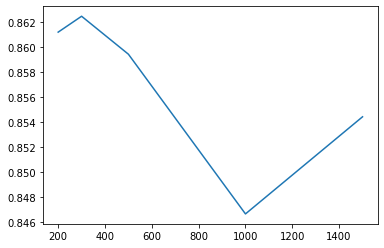

In [681]:
scores = {}

for n_estimators in [200, 300, 500, 1000, 1500]:
    score = run_model(n_estimators)
    scores[n_estimators] = score

scores = pd.Series(scores)
scores.plot()

In [1020]:
clf = GradientBoostingClassifier(n_estimators=200, max_depth=3, random_state=1)
#clf = SVC(C = 10, kernel='rbf')
clf.fit(X, y)
predictions = clf.predict(X_test)

output = pd.DataFrame({'PassengerId': test.PassengerId, 'Survived': predictions})
output.to_csv('submission.csv', index=False)
print("Your submission was successfully saved!")

Your submission was successfully saved!


## Feature engineering

### Tips on Creating Features
It's good to keep in mind your model's own strengths and weaknesses when creating features. Here are some guidelines:
- Linear models learn sums and differences naturally, but can't learn anything more complex.
- Ratios seem to be difficult for most models to learn. Ratio combinations often lead to some easy performance gains.
- Linear models and neural nets generally do better with normalized features. Neural nets especially need features scaled to values not too far from 0. Tree-based models (like random forests and XGBoost) can sometimes benefit from normalization, but usually much less so.
- Tree models can learn to approximate almost any combination of features, but when a combination is especially important they can still benefit from having it explicitly created, especially when data is limited.
- Counts are especially helpful for tree models, since these models don't have a natural way of aggregating information across many features at once.

In [81]:
import numpy as np 
import pandas as pd 
from scipy import stats
import matplotlib.pyplot as plt

train = pd.read_csv('titanic/train.csv')
test = pd.read_csv('titanic/test.csv')

In [82]:
train.replace({'Sex': {'male': 0, 'female': 1}}, inplace=True)
train['Age'].fillna(1000, inplace=True)
test['Fare'].fillna(train['Fare'].median(), inplace=True)

features = ['Pclass', 'Sex', 'Fare', 'Age', 'SibSp', 'Parch']
#features = ['Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'LogFare', 'Fare_Class']

X = train[features]
y = train["Survived"]

In [829]:
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()

X = sc.fit_transform(X)
X_test = sc.transform(X_test)

In [830]:
# Train and score baseline model
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(n_estimators=200, max_depth=7, random_state=1)
baseline_score = cross_val_score(clf, X, y, cv=5, scoring='roc_auc').mean()

print(f"baseline score: {baseline_score:.4}")

baseline score: 0.8671


In [83]:
from sklearn.feature_selection import mutual_info_classif

discrete_features = X.dtypes == int

def make_mi_scores(X, y, discrete_features):
    mi_scores = mutual_info_classif(X, y, discrete_features=discrete_features)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores

mi_scores = make_mi_scores(X, y, discrete_features)
mi_scores

Sex       0.150870
Fare      0.129130
Pclass    0.058107
Age       0.033120
SibSp     0.023197
Parch     0.016366
Name: MI Scores, dtype: float64

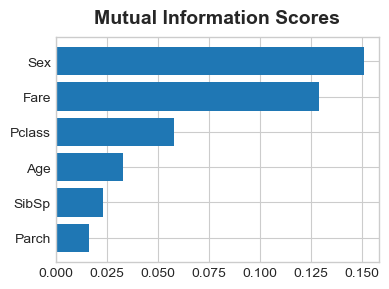

In [84]:
def plot_mi_scores(scores):
    scores = scores.sort_values(ascending=True)
    width = np.arange(len(scores))
    ticks = list(scores.index)
    plt.barh(width, scores)
    plt.yticks(width, ticks)
    plt.title("Mutual Information Scores")

plt.figure(dpi=100, figsize=(4, 3))
plot_mi_scores(mi_scores)

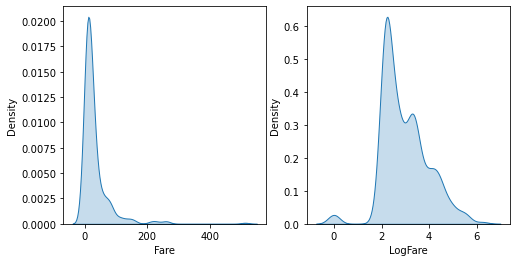

In [7]:
import seaborn as sns

train["LogFare"] = train.Fare.apply(np.log1p)
test["LogFare"] = test.Fare.apply(np.log1p)

# Plot a comparison
fig, axs = plt.subplots(1, 2, figsize=(8, 4))
sns.kdeplot(train.Fare, shade=True, ax=axs[0])
sns.kdeplot(train.LogFare, shade=True, ax=axs[1]);

In [56]:
train['Fare_Class'] = train['Fare'] / train['Pclass']
test['Fare_Class'] = test['Fare'] / test['Pclass']


train['Class_Fare'] = train['Pclass'] / train['Fare']
test['Class_Fare'] = test['Pclass'] / test['Fare']

In [58]:
calculate_r_squared_combintations(train)

0.4 Pclass + Sex + Age + SibSp + Parch
0.4 Pclass + Sex + Age + SibSp + Fare + Fare_Class
0.4 Pclass + Sex + Age + SibSp + Parch + Fare
0.4 Pclass + Sex + Age + SibSp + Fare_Class
0.4 Pclass + Sex + Age + SibSp + Fare
0.4 Pclass + Sex + Age + SibSp + Parch + Fare_Class
0.4 Pclass + Sex + Age + SibSp
0.39 Pclass + Sex + Age + Fare
0.39 Pclass + Sex + Age + Parch + Fare
0.39 Pclass + Sex + Age + Fare_Class
0.39 Pclass + Sex + Age + Fare + Fare_Class
0.39 Pclass + Sex + Age + Parch + Fare_Class
0.39 Pclass + Sex + Age + Parch
0.39 Pclass + Sex + Age
0.39 Pclass + Sex + Age + SibSp + Parch + Fare + Fare_Class


### PCA

In [85]:
features = [
    "Age",
    "Fare",
    "Sex",
    "Pclass",
    'Parch',
    'SibSp'
]

print("Correlation with Survived:\n")
print(train[features].corrwith(train.Survived))

Correlation with Survived:

Age      -0.094487
Fare      0.257307
Sex       0.543351
Pclass   -0.338481
Parch     0.081629
SibSp    -0.035322
dtype: float64


In [86]:
# `apply_pca`, defined above, reproduces the code from the tutorial
pca, X_pca, loadings = apply_pca(X)
print(loadings)

             PC1       PC2       PC3       PC4       PC5       PC6
Pclass -0.427414  0.574011 -0.140212 -0.095805  0.057137  0.675075
Sex     0.377172  0.118473  0.052731 -0.890622 -0.214600  0.040785
Fare    0.561835 -0.291463  0.269173  0.226756  0.081753  0.684715
Age    -0.236227  0.147140  0.932631 -0.075548  0.188293 -0.107629
SibSp   0.329106  0.559642  0.138247  0.369358 -0.636714 -0.132467
Parch   0.441911  0.486493 -0.127251  0.063735  0.709323 -0.211293


In [92]:
X.join(X_pca)

,Pclass,Sex,Fare,Age,SibSp,Parch,PC1,PC2,PC3,PC4,PC5,PC6
0,3,0,7.2500,22.0,1,0,-0.858321,0.469333,-0.652306,0.632215,-0.544180,0.282714
1,1,1,71.2833,38.0,1,0,1.667403,-1.025419,0.178768,-0.712800,-1.016708,-0.368976
2,3,1,7.9250,26.0,0,0,-0.362492,0.207250,-0.654073,-1.563695,-0.412699,0.496354
3,1,1,53.1000,35.0,1,0,1.463651,-0.919909,0.073056,-0.795187,-1.048079,-0.618687
4,3,0,8.0500,35.0,0,0,-1.155643,-0.037923,-0.742057,0.298386,0.040843,0.410252
...,...,...,...,...,...,...,...,...,...,...,...,...
886,2,0,13.0000,27.0,0,0,-0.583585,-0.756550,-0.566792,0.437123,-0.023241,-0.326758
887,1,1,30.0000,19.0,0,0,0.913791,-1.297997,-0.215937,-1.232420,-0.516464,-0.812408
888,3,1,23.4500,1000.0,1,2,0.614294,2.200562,1.583427,-1.189626,1.268628,-0.204597
889,1,0,30.0000,26.0,0,0,0.120445,-1.543196,-0.309411,0.629481,-0.064099,-0.899678


### Target encoding

In [95]:
train.select_dtypes(["object"]).nunique()

Name        891
Ticket      681
Cabin       147
Embarked      3
dtype: int64

## Model selection: Round 2

In [1043]:
from sklearn.model_selection import train_test_split


train_class = y.values
training_indices, validation_indices = training_indices, testing_indices = train_test_split(train.index,
                                                                                            stratify = train_class,
                                                                                            train_size=0.75, test_size=0.25)

from tpot import TPOTClassifier
from tpot import TPOTRegressor

tpot = TPOTClassifier(generations=5,verbosity=2)

tpot.fit(new_x.loc[training_indices].values,
         y.loc[training_indices].values)

Optimization Progress:   0%|          | 0/600 [00:00<?, ?pipeline/s]


Generation 1 - Current best internal CV score: 0.8398159578049601

Generation 2 - Current best internal CV score: 0.8398159578049601

Generation 3 - Current best internal CV score: 0.8398159578049601

Generation 4 - Current best internal CV score: 0.8428010324318258

Generation 5 - Current best internal CV score: 0.8457861070586915

Best pipeline: RandomForestClassifier(input_matrix, bootstrap=True, criterion=entropy, max_features=0.25, min_samples_leaf=1, min_samples_split=6, n_estimators=100)


TPOTClassifier(generations=5, verbosity=2)

## Util functions

In [44]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

def calculate_r_squared_combintations(data):
    # Let's find such a set of features that R-squared is maximum
    data = data.drop(columns=['PassengerId', 'Name', 'Ticket', 'Cabin', 'Embarked'])
    features = data.columns.to_list()
    features.remove('Survived')
    
    #features = {'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'LogFare'}
    #features = {'Pclass', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Fare_Class', 'Class_Fare'}

    # Recursively iterate over all combinations of variables
    def brute_force(params: set, formula: str, result: set) -> str:
        if not params:
            result.add(formula.lstrip('+ '))
            return 
        else:
            new_params = params.copy()
            for el in params:
                new_params.remove(el)

                brute_force(new_params, formula + ' + ' + el, result)
                brute_force(new_params, formula, result)

    res = set()          
    brute_force(features, '', res)
    res.remove('')

    results = {}

    # Now we calculate the Adjusted R-Square for each combination and display
    for formula in res:
        lm = smf.ols(formula='Survived ~ ' + formula, data=data).fit()

        results[formula] = f'{lm.rsquared_adj:.2}'

    sorted_keys = sorted(results, key=results.get, reverse=True)
    sorted_keys = sorted_keys[0:15]
    for r in sorted_keys:
        print(results[r], r)

In [24]:
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

def check_correlation(data):
    # check correlation between features
    corr = data.drop(columns=['Survived'])
    axes = pd.plotting.scatter_matrix(corr, figsize=(10,10), diagonal='kde', grid=True)

    data_corr = corr.corr().values
    for i, j in zip(*plt.np.triu_indices_from(axes, k=1)):
        axes[i, j].annotate("%.2f" %data_corr[i,j], (0.8, 0.8), xycoords='axes fraction', ha='center', va='center')
    plt.show()

In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.feature_selection import mutual_info_regression
from sklearn.model_selection import cross_val_score
from xgboost import XGBRegressor

# Set Matplotlib defaults
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc(
    "axes",
    labelweight="bold",
    labelsize="large",
    titleweight="bold",
    titlesize=14,
    titlepad=10,
)


def apply_pca(X, standardize=True):
    # Standardize
    if standardize:
        X = (X - X.mean(axis=0)) / X.std(axis=0)
    # Create principal components
    pca = PCA()
    X_pca = pca.fit_transform(X)
    # Convert to dataframe
    component_names = [f"PC{i+1}" for i in range(X_pca.shape[1])]
    X_pca = pd.DataFrame(X_pca, columns=component_names)
    # Create loadings
    loadings = pd.DataFrame(
        pca.components_.T,  # transpose the matrix of loadings
        columns=component_names,  # so the columns are the principal components
        index=X.columns,  # and the rows are the original features
    )
    return pca, X_pca, loadings


def plot_variance(pca, width=8, dpi=100):
    # Create figure
    fig, axs = plt.subplots(1, 2)
    n = pca.n_components_
    grid = np.arange(1, n + 1)
    # Explained variance
    evr = pca.explained_variance_ratio_
    axs[0].bar(grid, evr)
    axs[0].set(
        xlabel="Component", title="% Explained Variance", ylim=(0.0, 1.0)
    )
    # Cumulative Variance
    cv = np.cumsum(evr)
    axs[1].plot(np.r_[0, grid], np.r_[0, cv], "o-")
    axs[1].set(
        xlabel="Component", title="% Cumulative Variance", ylim=(0.0, 1.0)
    )
    # Set up figure
    fig.set(figwidth=8, dpi=100)
    return axs


def make_mi_scores(X, y):
    X = X.copy()
    for colname in X.select_dtypes(["object", "category"]):
        X[colname], _ = X[colname].factorize()
    # All discrete features should now have integer dtypes
    discrete_features = [pd.api.types.is_integer_dtype(t) for t in X.dtypes]
    mi_scores = mutual_info_regression(X, y, discrete_features=discrete_features, random_state=0)
    mi_scores = pd.Series(mi_scores, name="MI Scores", index=X.columns)
    mi_scores = mi_scores.sort_values(ascending=False)
    return mi_scores


def score_dataset(X, y, model=XGBRegressor()):
    # Label encoding for categoricals
    for colname in X.select_dtypes(["category", "object"]):
        X[colname], _ = X[colname].factorize()
    # Metric for Housing competition is RMSLE (Root Mean Squared Log Error)
    score = cross_val_score(
        model, X, y, cv=5, scoring="neg_mean_squared_log_error",
    )
    score = -1 * score.mean()
    score = np.sqrt(score)
    return score